In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import accuracy_score, make_scorer, f1_score
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from Symbol import SYMBOLS
from distances import MINDIST
import warnings 
import ruptures as rpt
#from dtw import dtw
##from sklearn.model_selection import GridSearchCV
#from tslearn.neighbors import KNeighborsTimeSeriesClassifier
#from tslearn.utils import to_time_series_dataset
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import precision_recall_curve, average_precision_score
#from sklearn.metrics import roc_curve, auc

from SAX_transf import *
from utils import *
from ASTRIDE import *

warnings.filterwarnings('ignore')
import os
import aeon
from aeon.datasets import load_classification

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
train_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TRAIN.ts")
test_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TEST.ts")

X_train = pd.read_csv(train_path, 
                      sep=",", 
                      header=None
                      )

X_train.columns = list(X_train.columns[:-1]) + ['label']
x_train, y_train = X_train.iloc[:, :-1], X_train["label"]

y_train = y_train.replace(-1, 0)

X_test = pd.read_csv(test_path, 
                      sep=",", 
                      header=None
                      )

X_test.columns = list(X_test.columns[:-1]) + ['label']
x_test, y_test = X_test.iloc[:, :-1], X_test["label"]

y_test = y_test.replace(-1, 0)

In [3]:
scaled_x_test = std_scaler(x_test)
sax_trans = SAX_transform(scaled_x_test.iloc[0], 20, 5)
D_sax_rep = sax_trans.transf_1d_sax(8, 8)
D_sax_rep

esax_rep = sax_trans.calculate_esax()
esax_rep

'deeadeddeabcaaaaaaaaaaaaaaaabcddedeeddedddddddddcddccddddccd'

Voici la nouvelle représentation ESAX: eddbaaaaabdedddddcdc et sa taille20


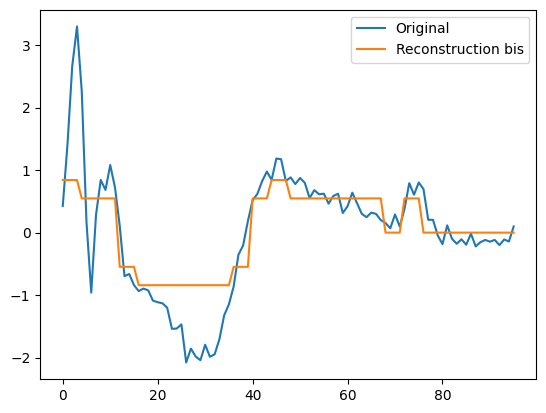

In [7]:
reconstruction = sax_trans.reconstruction_from_sax(esax_rep)
reconstruction_bis = sax_trans.reconstruction_from_sax(esax_rep, option='esax')

plt.plot(scaled_x_test.iloc[0], label='Original')
#plt.plot(reconstruction, label='Reconstruction')
plt.plot(reconstruction_bis, label='Reconstruction bis')
plt.legend()
plt.show()

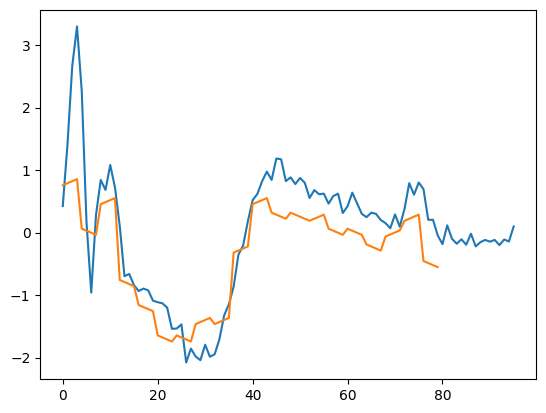

In [ ]:
reconstructed_serie = sax_trans.reconstruct_from_1d_sax(D_sax_rep, 20, 5)

plt.plot(test_serie_centered)
plt.plot(reconstructed_serie)
plt.show()

In [ ]:
one_knn = SYMBOLS(X_train=X_train,
                  X_test=X_test,
                  method="oneD_SAX",
                  Na= 4, 
                  Ns= 4,
                  )

In [ ]:
one_knn.predict_oneD()

Accuracy:0.64


ASTRIDE TESTSS

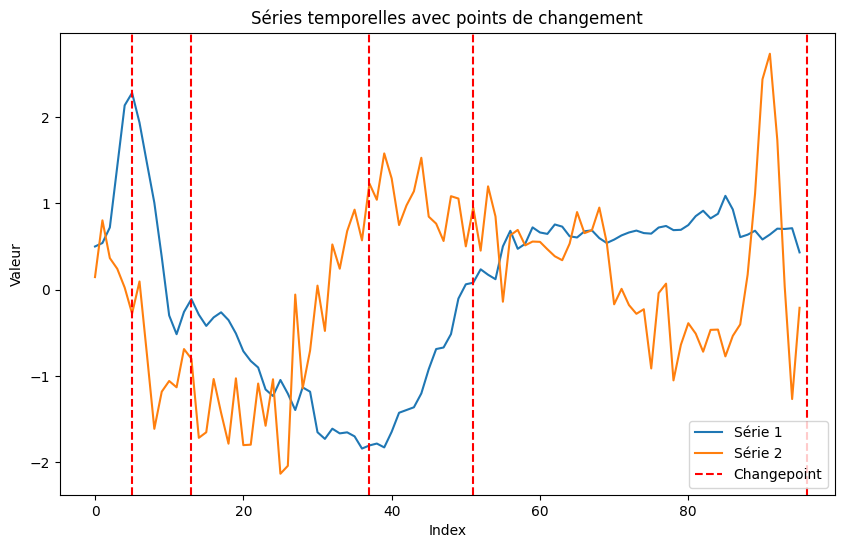

In [4]:
dataset_np = std_scaler(x_train)
dataset_np = dataset_np.to_numpy()

astride = ASTRIDE_transf(dataset_np, 5, 5)
astride.segmentation_adaptive()
astride.mts_bkps_


ex_serie_1 = dataset_np[0]
ex_serie_2 = dataset_np[1]

plt.figure(figsize=(10, 6))
plt.plot(ex_serie_1, label='Série 1')
plt.plot(ex_serie_2, label='Série 2')

# Ajout des changepoints (mts_bkps_)
for cp in astride.mts_bkps_:
    plt.axvline(x=cp, color='red', linestyle='--', label='Changepoint' if 'Changepoint' not in plt.gca().get_legend_handles_labels()[1] else "")

# Ajouter légende et afficher
plt.legend()
plt.title("Séries temporelles avec points de changement")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.show()

In [5]:
symbols = astride._ASTRIDE_symbolize()
symbols

[3, 1, 2, 5]

Brouillon pour la traduction de ESAX, au final on prend que la moyenne

In [ ]:
if option == "esax":
            sax_representation = [sax_representation[i:i+3] for i in range(0, len(sax_representation), 3)]
            for symbols in sax_representation:
                averaga_symbol = 
                
                
                
                if ord(symbols[1]) == 122:
                    paa_values.append(breakpoints[-1])
                elif ord(symbols[1]) == 97:
                    paa_values.append(breakpoints[0])
                else: 
                    paa_val_0 = np.mean([breakpoints[ord(symbols[0]) - 97], breakpoints[ord(symbols[0]) - 96]])
                    paa_val_1 = np.mean([breakpoints[ord(symbols[1]) - 97], breakpoints[ord(symbols[1]) - 96]])
                    paa_val_2 = np.mean([breakpoints[ord(symbols[2]) - 97], breakpoints[ord(symbols[2]) - 96]])
                    paa_values.append(np.mean([paa_val_0, paa_val_1, paa_val_2]))
        